# Neural Network (cont)
Trong bài học trước, chúng ta đã làm quen với các bước cơ bản trong xây dựng mạng nơ-ron với thư viện <b>Keras</b>. Trong bài tập tuần này, chúng ta sẽ tiếp tục làm quen với các phương pháp để tối ưu hóa mạng nơ-ron.

# Import dữ liệu

In [1]:
# Import một số thư viện cần thiết.
import random
import numpy as np
import matplotlib.pyplot as plt
import keras

# Sử dụng một mẹo nhỏ để vẽ hình trên cùng một dòng thay vì mở cửa sổ mới
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # đặt kích thước mặc định cho hình
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Một mẹo nhỏ để notebook tự load lại các module bên ngoài;
# xem thêm tại http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

/home/lego1st/.virtualenvs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Tải dữ liệu Cifar10 từ Keras và chia thành dữ liệu huấn luyện và kiểm tra.
from keras.datasets import cifar10

# Dũ liệu CIFAR10 gồm 50,000 ảnh màu kích thước 32x32 để huấn luyện, gồm 10 chuyên mục, và 10,000 ảnh kiểm tra.
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000, 1)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000, 1)


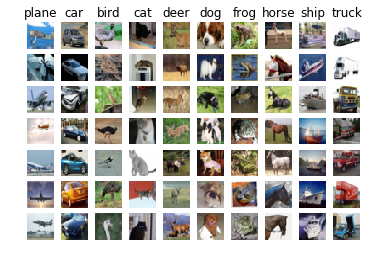

In [3]:
# Hiển thị một số ảnh từ trong bộ dữ liệu.
# Với mỗi lớp, chúng ta sẽ hiển thị một số ảnh minh họa.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Lấy 1 phần nhỏ dữ liệu để huấn luyện hiệu quả hơn trong bài tập này
num_training = 5000
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

In [5]:
# # Định dạng lại hình ảnh thành các hàng
# X_train = np.reshape(X_train, (X_train.shape[0], -1))
# X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)
print(y_train.shape)

(5000, 32, 32, 3) (500, 32, 32, 3)
(5000, 1)


# Xây dựng mô hình với Keras

Như đã học tuần trước, để xây dựng mô hình mạng nơ-ron với `Keras`, ta có thể sử dụng hai phương pháp:
- Xây dựng mô hình tuần tự
- Xây dựng API chức năng 

**Bài tập:** Sử dụng API chức năng để xây dựng mô hình có cấu trúc như mô tả sau:
- Tầng đầu vào nhận input là ảnh CIFAR10, hàm kích hoạt là relu, units=2048
- Tầng ẩn thứ nhất: đầu ra có số chiều là 2048, hàm kích hoạt là relu
- Tầng ẩn thứ hai: đầu ra có số chiều là 1024, hàm kích hoạt là tanh
- Tầng ẩn thứ ba: đầu ra có số chiều là 256, hàm kích hoạt là tanh

In [6]:
# import các class cần thiết từ thư viện Keras
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense
from keras.layers import Activation

# khởi tạo mô hình có tầng đầu vào với biến inputs
inputs = Input(shape=X_train.shape[1:])

# Trong phần dưới đây, bổ sung cấu trúc của các tầng ẩn kế tiếp
first_hid_layer = Dense(2048, activation='relu')(inputs)
second_hid_layer = Dense(1024, activation='tanh')(first_hid_layer)
third_hid_layer = Dense(256, activation='tanh')(second_hid_layer)

## Max pooling
Max pooling là một quy trình lấy đại diện dựa trên mẫu. Mục tiêu là lấy mẫu đại diện đầu vào (hình ảnh, ma trận đầu ra của lớp ẩn,...), giảm chiều kích của nó và tránh trường hợp quá khớp của mô hình.

Max-pooling áp dụng bộ lọc kích thước `n x n` và giữ lại giá trị lớn nhất trong mỗi lưới lọc.
<img src="max-pooling.jpg">

Trong `Keras`, ta sử dụng hàm các hàm <b>MaxPooling</b> với một số tham số quan trọng:
- <b>pool_size</b>: kích thước của cửa sổ lọc max pooling (kiểu nguyên)
- <b>strides</b>: độ dịch của cửa sổ lọc (kiểu nguyên hoặc None)
- <b>padding</b>: nhận giá trị `valid` hoặc `same`

Đọc thêm về lớp Pooling tại [đây](https://keras.io/layers/pooling/)

**Bài tập:** Thêm lớp MaxPooling vào cuối tầng ẩn thứ ba với kích thước cửa sổ lọc là 3.

In [7]:
from keras.layers import MaxPooling2D
# flatted_third_hid_layer = Flatten()(third_hid_layer)
# print(third_hid_layer.shape)
# Với mô hình đã xây dựng ở trên, ta thêm một lớp pooling vào cuối
max_pool = MaxPooling2D(pool_size=(3,3), strides=2, padding="valid")(third_hid_layer)

## Dropout

Mục đích của dropout là để giảm số đặc trưng của dữ liệu, tránh overfit.

Trong `Keras`, dropout được cài đặt trong class <b>Dropout</b> với tham số quan trọng nhất là `rate` là một số thực trong khoảng [0,1] là tỉ lệ drop của input.
<img src="drop.png">

**Bài tập:** Thêm lớp Dropout vào dưới lớp cuối cùng với tỉ lệ drop là 0.4.

In [8]:
from keras.layers import Dropout, Flatten

# Thêm lớp dropout vào sau lớp pooling
dropout = Dropout(rate=0.4)(max_pool)

# Với cấu trúc mô hình ở trên, ta biên dịch mô hình
# tầng đầu ra có số chiều bằng class với hàm kích hoạt Softmax
flatten = Flatten()(dropout)
predictions = Dense(units=num_classes, activation="softmax")(flatten)
predictions = Dense(1)(predictions)
api_model = Model(inputs=inputs, outputs=predictions)

api_model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['accuracy'])

## Batch Norm

Cuối cùng, khi huấn luyện mô hình, để tăng tốc độ huấn luyện và khả năng hội tụ của mô hình, <b>Batch norm</b> là một kỹ thuật không thể bỏ qua.

In [9]:
# Huấn luyện mô hình với tham số batch_size bằng 32
api_model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
5000/5000 [==============================] - 296s 59ms/step - loss: 21.4933 - acc: 0.0920
Epoch 2/100
5000/5000 [==============================] - 284s 57ms/step - loss: 19.3086 - acc: 0.0920
Epoch 3/100
5000/5000 [==============================] - 357s 71ms/step - loss: 17.3472 - acc: 0.0958
Epoch 4/100
5000/5000 [==============================] - 296s 59ms/step - loss: 15.6047 - acc: 0.1038
Epoch 5/100
5000/5000 [==============================] - 301s 60ms/step - loss: 14.0283 - acc: 0.1038
Epoch 6/100
5000/5000 [==============================] - 330s 66ms/step - loss: 12.6670 - acc: 0.0980
Epoch 7/100
5000/5000 [==============================] - 331s 66ms/step - loss: 11.4975 - acc: 0.0972
Epoch 8/100
5000/5000 [==============================] - 281s 56ms/step - loss: 10.5135 - acc: 0.0972
Epoch 9/100
5000/5000 [==============================] - 272s 54ms/step - loss: 9.7294 - acc: 0.0972
Epoch 10/100
5000/5000 [==============================] - 398s 80ms/step - loss: 9.

KeyboardInterrupt: 

Em xin dừng vì loss đã bão hòa và máy yếu :D

** Bài tập: ** Chọn ra kích thước `batch_size` tối ưu để mô hình đạt hiệu năng tốt nhất.

In [ ]:
# Code ở đây

*Áp dụng các phương pháp trên để tối ưu mô hình trong bài tập lớn.*